# Load cleaned data

In [10]:
import os, sys
path = os.path.join(os.path.abspath(""), 'internship-env', 'Lib', 'site-packages')
sys.path.append(path)

import glob
import json
import string
import math
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.model_selection import train_test_split
from collections import Counter
import random
random.seed(42)

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pywsd
from pywsd.utils import lemmatize_sentence
from wordcloud import WordCloud, STOPWORDS

# LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# LDA evaluation
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

#pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pyLDAvis.enable_notebook()

#NLTK packages
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.probability import MLEProbDist
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
# Define stop words
stop_words = set(stopwords.words("english"))

In [12]:
# ========================= Columns =========================
commit_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Sha', 'Message']
code_file_columns = ['Type', 'URL', 'RepoName']
repo_columns = ['Type', 'URL', 'RepoName', 'RepoLanguage']
issue_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'AuthorAt', 'ClosedAt', 'UpdatedAt', 'State']
pull_request_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'CreatedAt', 'ClosedAt', 'MergedAt', 'UpdatedAt', 'State', 'Additions', 'Deletions', 'ChangedFiles', 'CommitsTotalCount', 'CommitSha']
hacker_news_columns = ['Type', 'ID', 'URL', 'AttachedURL', 'Title', 'CreatedAt']
discussion_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'AuthorAt', 'ClosedAt', 'UpdatedAt', 'Closed', 'UpvoteCount']
mention_columns = ['MentionedURL', 'MentionedProperty', 'MentionedAuthor', 'MentionedText', 'MentionedPath','MentionedAnswer', 'MentionedUpvoteCount']
gpt_sharing_columns = ['SharingURL', 'Status', 'DateOfConversation', 'DateOfAccess', 'NumberOfPrompts', 'TokensOfPrompts', 'TokensOfAnswers', 'Model', 'Conversations']

# ========================= Processing functions =========================
def process_commit_json(commit):
    commit_array_of_elements = [commit[col] for col in (commit_columns + gpt_sharing_columns + mention_columns)]
    return commit_array_of_elements

def process_code_files_json(code_file):
    code_files_array_of_elements = [code_file[col] for col in (code_file_columns + gpt_sharing_columns + mention_columns)]
    return code_files_array_of_elements

def process_repo_json(repo):
    repo_array_of_elements = [repo[col] for col in (repo_columns + gpt_sharing_columns + mention_columns)]
    return repo_array_of_elements

def process_issue_json(issue):
    issue_array_of_elements = [issue[col] for col in (issue_columns + gpt_sharing_columns + mention_columns)]
    return issue_array_of_elements

def process_pull_request_json(pull_request):
    pull_request_array_of_elements = [pull_request[col] for col in (pull_request_columns + gpt_sharing_columns + mention_columns)]
    return pull_request_array_of_elements

def process_hacker_news_json(hacker_news):
    hacker_news_array_of_elements = [hacker_news[col] for col in (hacker_news_columns + gpt_sharing_columns + mention_columns)]
    return hacker_news_array_of_elements

def process_discussion_json(discussion):
    discussion_array_of_elements = [discussion[col] for col in (discussion_columns + gpt_sharing_columns + mention_columns)]
    return discussion_array_of_elements

In [13]:
def read_json_data_from_files_to_dataframe(json_filepath):
    file_sharings_df = pd.DataFrame()
    with open(json_filepath, 'r', encoding='utf-8') as file:
        # Load JSON data from file
        json_data = json.load(file)
        data_to_df = []
        for source in json_data:
            source_array = []
            columns_for_df = []
            if source['Type'] == 'commit':
                source_array = process_commit_json(source)
                columns_for_df = commit_columns
            elif source['Type'] == 'code file':
                source_array = process_code_files_json(source)
                columns_for_df = code_file_columns
            elif source['Type'] == 'repository':
                source_array = process_repo_json(source)
                columns_for_df = repo_columns
            elif source['Type'] == 'issue':
                source_array = process_issue_json(source)
                columns_for_df = issue_columns
            elif source['Type'] == 'pull request':
                source_array = process_pull_request_json(source)
                columns_for_df = pull_request_columns
            elif source['Type'] == 'hacker news':
                source_array = process_hacker_news_json(source)
                columns_for_df = hacker_news_columns
            elif source['Type'] == 'discussion':
                source_array = process_discussion_json(source)
                columns_for_df = discussion_columns
            else:
                print(f"Unexpected type of the course: '{source['Type']}'")
                raise
            data_to_df.append(source_array)
        file_dataframe = pd.DataFrame(data_to_df, columns=(columns_for_df + gpt_sharing_columns + mention_columns))
        file_sharings_df = pd.concat([file_sharings_df, file_dataframe])
    return file_sharings_df

In [14]:
cleaned_dir_name = "cleaned_datasets"
tokenized_dir_name = "tokenized_datasets"
dataframe_names = ["commits", "issues", "discussions", "pull_requests", "code_files", "repository", "hacker_news"]
cleaned_dataframe_file_names = [f"{cleaned_dir_name}/cleaned_{df_name}.json" for df_name in dataframe_names]
tokenized_dataframe_file_names = [f"{tokenized_dir_name}/tokenized_{df_name}.json" for df_name in dataframe_names]

read_tokenised_file = True

In [15]:
def lemmatize_tokenize_all_prompts(prompt):
    tokens = lemmatize_sentence(prompt)
    tokens = [word for word in tokens if word.isascii()]
    tokens = [word for word in tokens if not word.startswith('http')]
    tokens = [word for word in tokens if word.lower() not in stop_words]
    tokens = [word for word in tokens if word not in string.punctuation]
    tokens = [word for word in tokens if word.isalpha()]
    return tokens

lemmatised_dataframes = []

if read_tokenised_file and os.path.exists(tokenized_dir_name):
    for df_path in tokenized_dataframe_file_names:
        with open(df_path, 'r', encoding='utf-8') as file:
            json_data = json.load(file)
            lemmatised_dataframes.append(pd.json_normalize(json_data))
else:
    for filename in cleaned_dataframe_file_names:
        dataframe = read_json_data_from_files_to_dataframe(filename)
        conv_prompts = []
        for index, df_row in dataframe.iterrows():
            conversations = df_row["Conversations"]
            for conv in conversations:
                conv_prompts.append(conv["Prompt"])
        prompts_df = pd.DataFrame(conv_prompts, columns=["Prompts"])
        prompts_df["Prompts"] = prompts_df["Prompts"].map(lambda x: lemmatize_tokenize_all_prompts(x))
        lemmatised_dataframes.append(prompts_df)
    if not os.path.exists(tokenized_dir_name):
       os.mkdir(tokenized_dir_name)
    for i, dataframe in enumerate(lemmatised_dataframes):
        dataframe.reset_index(drop=True, inplace=True)
        jso = dataframe.to_json(orient='records')
        with open(tokenized_dataframe_file_names[i], 'w', encoding='utf-8') as file:
            json.dump(json.loads(jso), file)
assert(len(lemmatised_dataframes) == len(dataframe_names))

In [16]:
research_imgs_dir = "research_imgs"

if not os.path.exists(research_imgs_dir):
    os.mkdir(research_imgs_dir)

# N-grams

In [17]:
def prompts_ngrams(prompts, n):
    n_grams = []
    for prompt in prompts:
        for gram in nltk.ngrams(prompt, n):
            token_counts = Counter(gram) # Count each word occurence in n-gram
            # Keep only n-grams that have the same word occur less than 3 times
            if all(count < 3 for count in token_counts.values()): 
                n_grams.append(gram)
    return nltk.FreqDist(n_grams)

def plot_dist_as_cloud(prompts_ngrams, n, axs, axs_i, axs_j, max_words, dataframe_name):
    prob_dist = MLEProbDist(prompts_ngrams)
    visualisation_dict = {}
    for word_freq_tuple in prompts_ngrams:
        string = ' '.join(word_freq_tuple)
        visualisation_dict[string] = prob_dist.prob(word_freq_tuple)
    cloud = WordCloud(width=1000, height=500, max_words=max_words).generate_from_frequencies(visualisation_dict)
    axs[axs_i, axs_j].imshow(cloud, interpolation='bilinear')
    axs[axs_i, axs_j].set_title(f"Wordcloud for {n}-grams with the set max_words argument to {max_words}.")

In [18]:
ns = range(2,5)

for idx, df in enumerate(lemmatised_dataframes):
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(30,15), layout="constrained")
    for n in ns:
        print(f"-------- {n}-grams {dataframe_names[idx]} --------")
        i,j =  divmod(n-1, 2)
        all_ngrams_frequencies = prompts_ngrams(df["Prompts"].tolist(), n)
        most_common_ngrams = all_ngrams_frequencies.most_common(25)
        for word_freq_tuple in most_common_ngrams:
            print(word_freq_tuple)
        plot_dist_as_cloud(all_ngrams_frequencies, n, axs, i, j, 50, dataframe_names[idx])
    fig.savefig(f'{research_imgs_dir}/{dataframe_names[idx]}-ngrams.png')   # save the figure to file
    plt.close(fig)
    plt.show()
    print("===========================================================================")

-------- 2-grams commits --------
(('solve', 'task'), 1649)
(('working', 'set'), 1170)
(('need', 'file'), 750)
(('output', 'format'), 702)
(('shell', 'script'), 671)
(('script', 'create'), 663)
(('change', 'file'), 660)
(('full', 'file'), 660)
(('create', 'change'), 658)
(('file', 'everything'), 657)
(('everything', 'solve'), 657)
(('encode', 'enclose'), 646)
(('enclose', 'result'), 646)
(('result', 'shell'), 646)
(('format', 'encode'), 645)
(('task', 'file'), 618)
(('file', 'small'), 606)
(('file', 'need'), 598)
(('edit', 'file'), 550)
(('work', 'set'), 535)
(('use', 'sed'), 503)
(('avoid', 'use'), 502)
(('project', 'specific'), 463)
(('small', 'avoid'), 460)
(('sed', 'favor'), 460)
-------- 3-grams commits --------
(('shell', 'script', 'create'), 661)
(('script', 'create', 'change'), 657)
(('create', 'change', 'file'), 657)
(('change', 'file', 'everything'), 657)
(('file', 'everything', 'solve'), 657)
(('everything', 'solve', 'task'), 657)
(('encode', 'enclose', 'result'), 646)
(('en

# Pattern mining

In [10]:
from sequential.seq2pat import Seq2Pat

dir_name = "sequences"

if not os.path.exists(dir_name):
    os.mkdir(dir_name)
dataframe_file_names = [f"{dir_name}/{name}.json" for name in dataframe_names]

for idx, df in enumerate(lemmatised_dataframes):
    if df.empty:
        continue
    sequences = [prompt for prompt in df["Prompts"] if prompt]
    min_frequency = max(1, round(len(df) / 50))
    seq2pat = Seq2Pat(sequences=sequences,
                  max_span=10,
                  batch_size=10000,
                  discount_factor=0.2,
                  n_jobs=os.cpu_count())
    print(f"Minimum frequency for {dataframe_names[idx]} set to {min_frequency}.")
    patterns_entire_set = seq2pat.get_patterns(min_frequency=min_frequency)
    with open(dataframe_file_names[idx], 'w') as file:
        json.dump(patterns_entire_set, file)
    #print(patterns_entire_set)

Minimum frequency for commits set to 54.
Minimum frequency for issues set to 90.
Minimum frequency for discussions set to 8.
Minimum frequency for pull_requests set to 45.
Minimum frequency for code_files set to 1069.
Minimum frequency for repository set to 3.
Minimum frequency for hacker_news set to 60.


In [15]:
def sublist(sublist, test_list):
    res = False
    for idx in range(len(test_list) - len(sublist) + 1):
        if test_list[idx: idx + len(sublist)] == sublist:
            res = True
            break
    return res

for i, df in enumerate(lemmatised_dataframes):
    counter = 0;
    for elem in df.Prompts.tolist():
        if sublist(['file', 'file'], elem):
            counter += 1 #print(str(i) + ' - ' + str(elem))
    print(counter)

4
27
0
4
99
0
6


# Topic modelling

In [11]:
def process_reviews_into_dictionary_and_corpus(reviews_ngram_data, n):
    if n > 1:
        reviews_ngram_data = [("_".join(reviews_tuple),) for reviews_tuple in reviews_ngram_data]
        dictionary = corpora.Dictionary(reviews_ngram_data)
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in reviews_ngram_data]
    elif n == 1:
        dictionary = corpora.Dictionary(reviews_ngram_data)
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in reviews_ngram_data]
    else:
        raise Exception('n should be positive integer')
    return dictionary, doc_term_matrix

def topic_modelling_visualisation(top_n, topics_dicts, dataset_name, enumeration):
    cols = [color for _, color in mcolors.TABLEAU_COLORS.items()]
    cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=top_n,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

    fig, axs = plt.subplots(2,math.ceil(len(topics_dicts)/2), figsize=(15,10))
    axs = axs.ravel()
    for i in range(len(topics_dicts)):
        cloud.generate_from_frequencies(topics_dicts[i], max_font_size=300)
        axs[i].imshow(cloud)
        axs[i].set_title('Topic ' + str(i), fontdict=dict(size=16))
        axs[i].axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()
    print(f"Figure {enumeration}: Topic modelling for {dataset_name} dataset\n")

# Code source: https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/nlp/topic-modeling-naive.html#topic=0&lambda=1&term=

def get_topics_meanings(tw_m,
                        vocab,
                        display_weights=False,
                        topn=5,
                        weight_cutoff=0.6):
    for i, topic_weights in enumerate(tw_m):  ## for each topic row
        topic = [(token, np.round(weight, 2))
                 for token, weight in zip(vocab, topic_weights)
                 ]  ## zip (word, importance_weight)
        topic = sorted(topic,
                       key=lambda x: -x[1])  ## rank words according to weights
        topic_topn = topic[:topn]
        if display_weights:
            topic = [item for item in topic_topn if item[1] > weight_cutoff
                     ]  ## output words whose weights > 0.6
            print(f"Topic #{i+1} :\n{topic}")
            print("=" * 20)
        else:
            topic_topn = ' '.join([word for word, weight in topic_topn])
            print(f"Topic #{i} :\n{topic_topn}")
            print('=' * 20)

-----------------------------------------------------------------------
Topic modelling for commits.
Topic #1 :
[('junior', 114.87), ('file', 62.95), ('use', 62.19), ('part', 40.0), ('name', 34.53), ('development', 33.05), ('model', 30.7), ('command', 30.05), ('run', 29.93), ('pilotredsun', 29.17)]
Topic #2 :
[('npm', 61.43), ('button', 56.24), ('script', 54.89), ('web', 52.77), ('file', 50.72), ('run', 48.28), ('interface', 47.09), ('change', 45.89), ('use', 45.82), ('description', 45.64)]
Topic #3 :
[('file', 3512.45), ('task', 1397.94), ('need', 1203.66), ('create', 1194.18), ('use', 1139.54), ('set', 1130.98), ('solve task', 1122.68), ('solve', 1120.88), ('script', 878.45), ('working', 644.23)]
Topic #4 :
[('data', 63.73), ('use', 61.46), ('name', 46.31), ('file', 42.11), ('make', 41.44), ('script', 36.1), ('like', 29.06), ('need', 27.92), ('http', 27.45), ('also', 25.66)]
Topic #5 :
[('use', 43.81), ('file', 22.97), ('run', 21.38)]
Topic #6 :
[('file', 515.8), ('task', 211.77), ('

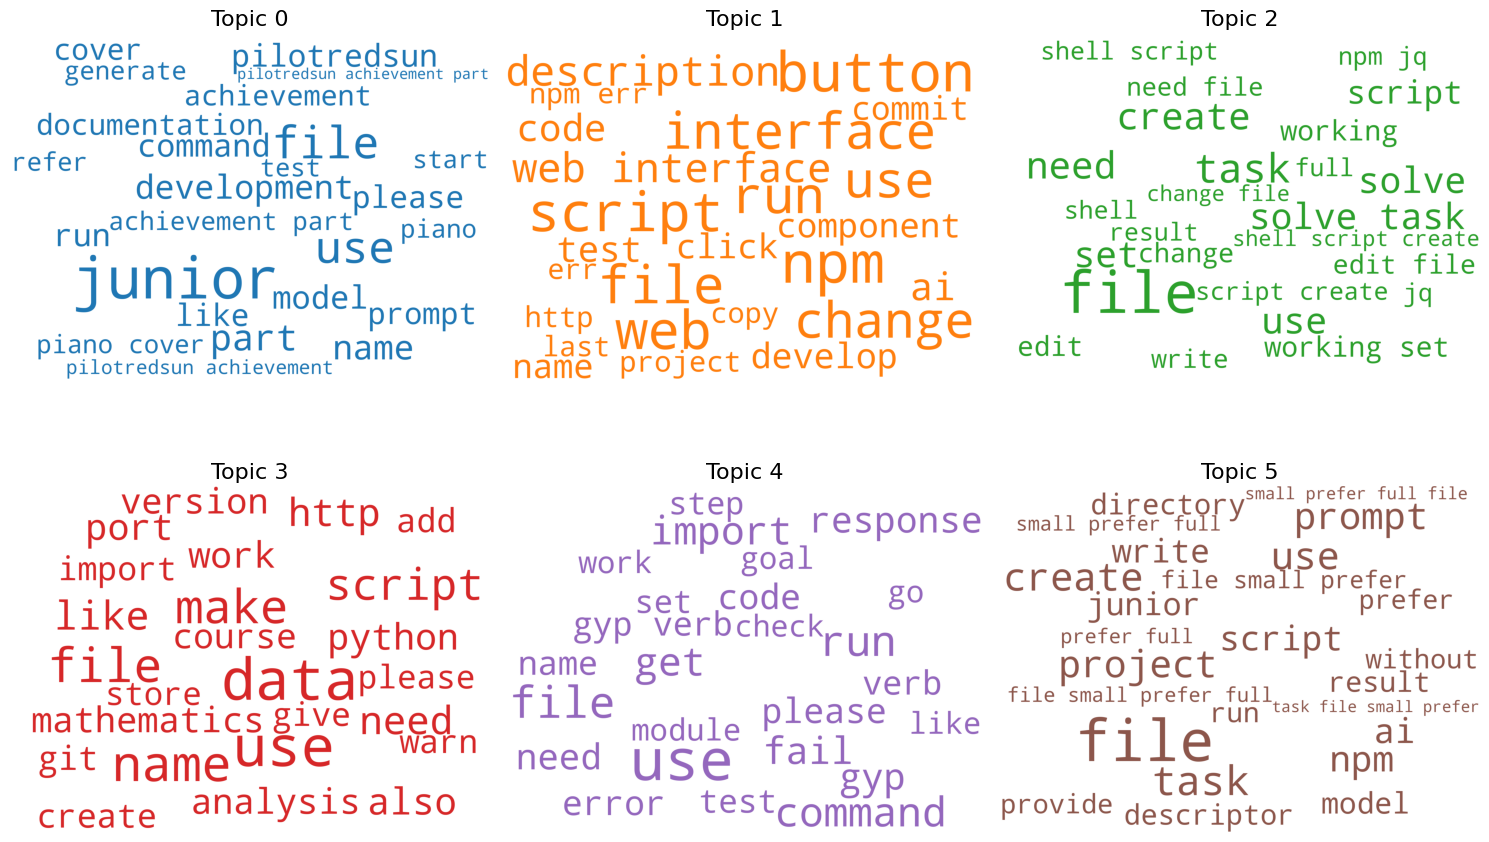

Figure 0: Topic modelling for commits dataset

Model coherence score: 0.5563
Model perplexity: 5449.2712
-----------------------------------------------------------------------
Topic modelling for issues.
Topic #1 :
[('use', 135.09), ('model', 54.17), ('would', 46.17), ('user', 45.17), ('code', 40.17), ('make', 40.17), ('need', 39.69), ('run', 33.96), ('token', 31.17), ('base', 31.12)]
Topic #2 :
[('use', 146.82), ('model', 129.0), ('file', 115.1), ('attention', 86.17), ('code', 71.42), ('layer', 67.13), ('output', 62.81), ('run', 54.18), ('position', 53.17), ('also', 50.17)]
Topic #3 :
[('file', 181.79), ('component', 136.15), ('error', 129.19), ('could', 125.1), ('error could', 112.17), ('rename', 112.14), ('component file', 110.17), ('could rename', 110.17), ('could rename component', 110.17), ('could rename component file', 110.17)]
Topic #4 :
[('li', 99.17), ('use', 92.61), ('http', 81.94), ('fix', 61.97), ('number', 54.17), ('code', 51.67), ('li fix', 51.17), ('please', 49.58), (

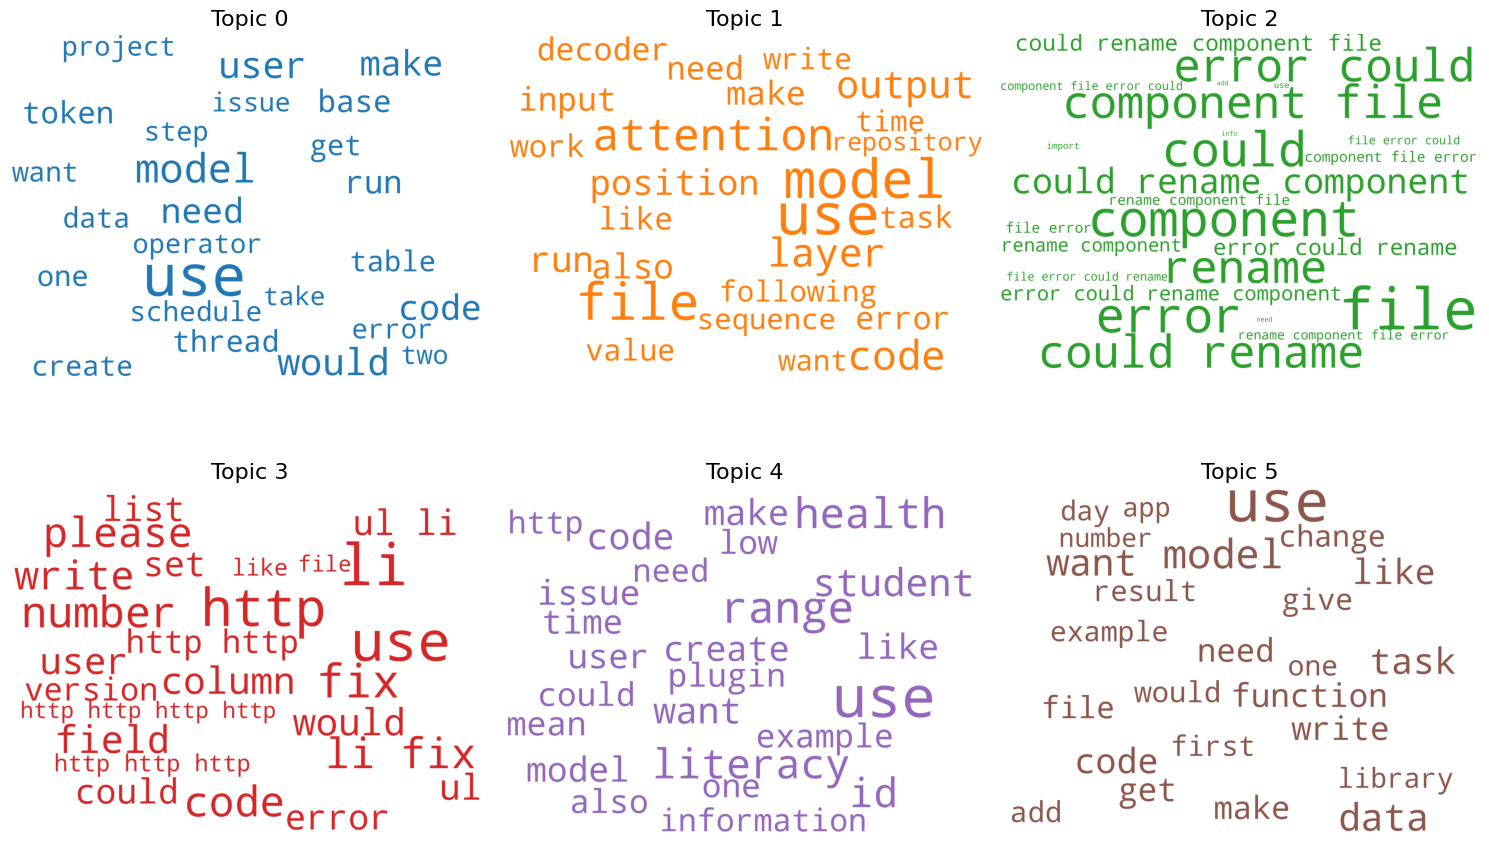

Figure 1: Topic modelling for issues dataset

Model coherence score: nan
Model perplexity: 69367.8252
-----------------------------------------------------------------------
Topic modelling for discussions.
Topic #1 :
[('model', 31.13), ('use', 23.17)]
Topic #2 :
[]
Topic #3 :
[]
Topic #4 :
[]
Topic #5 :
[]
Topic #6 :
[('object', 33.17)]


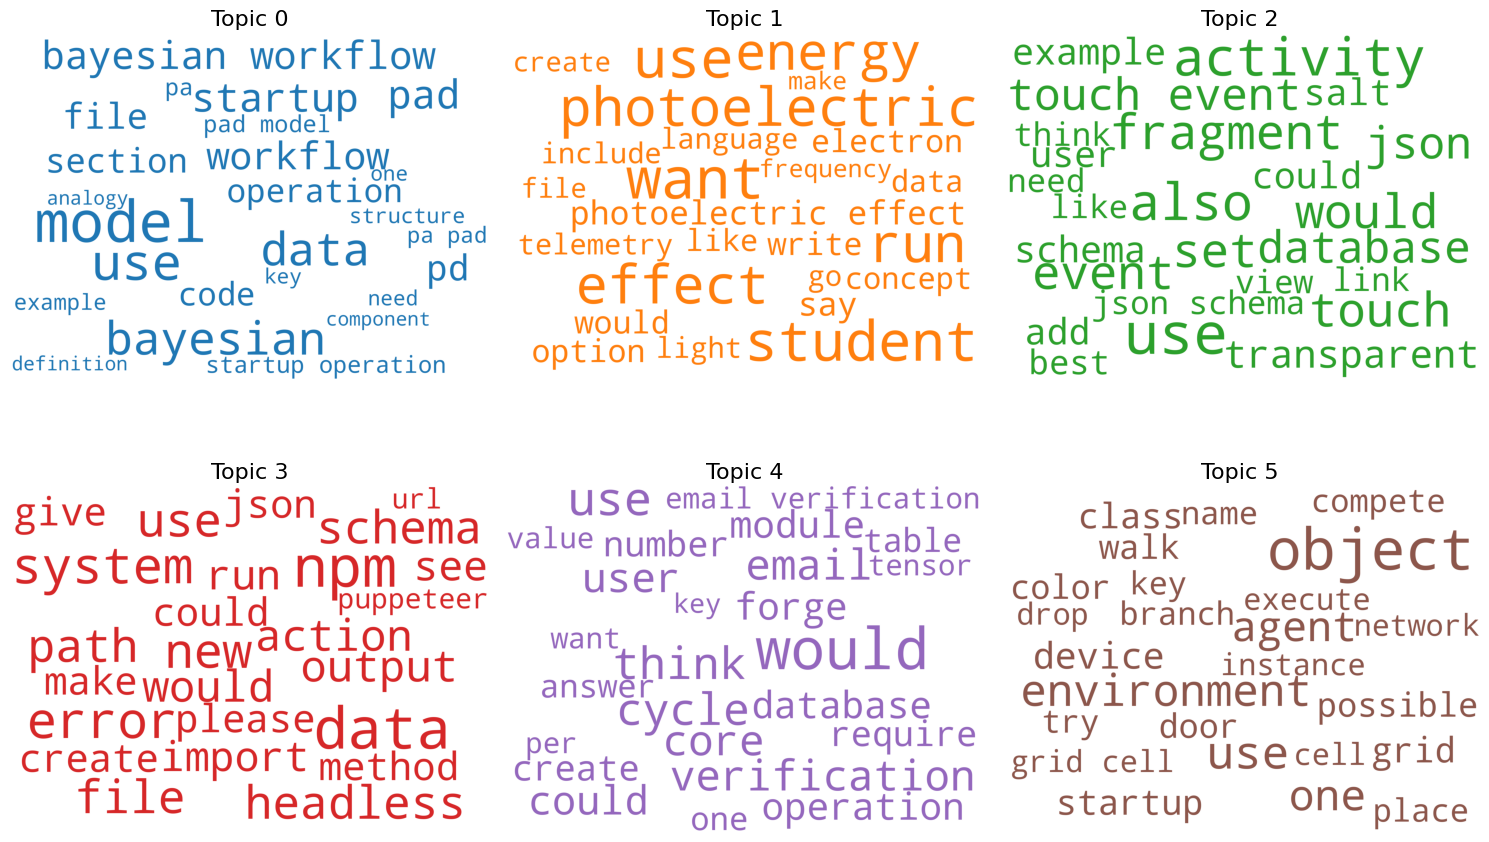

Figure 2: Topic modelling for discussions dataset

Model coherence score: 0.5130
Model perplexity: 17150.5313
-----------------------------------------------------------------------
Topic modelling for pull requests.
Topic #1 :
[('description', 40.17), ('file', 36.01), ('use', 27.17), ('component', 21.17)]
Topic #2 :
[('get', 54.99), ('go', 53.92), ('file', 52.18), ('want', 50.69), ('save', 48.17), ('use', 43.17), ('change', 39.18), ('git', 38.13), ('make', 33.17), ('branch', 32.95)]
Topic #3 :
[('use', 58.16), ('npm', 53.79), ('attester', 40.17), ('web', 40.17), ('attestation', 39.17), ('user', 34.17), ('err', 32.17), ('npm err', 32.17), ('run', 30.74), ('test', 29.41)]
Topic #4 :
[('subclassof', 132.17), ('cavity', 71.17), ('use', 70.16), ('entity', 68.17), ('part', 56.17), ('cell', 51.17), ('run', 51.03), ('cavity lumen', 48.17), ('coelemic', 48.17), ('coelemic cavity', 48.17)]
Topic #5 :
[('pip', 46.18), ('use', 41.17), ('file', 32.17), ('package', 29.18), ('change', 20.17)]
Topic 

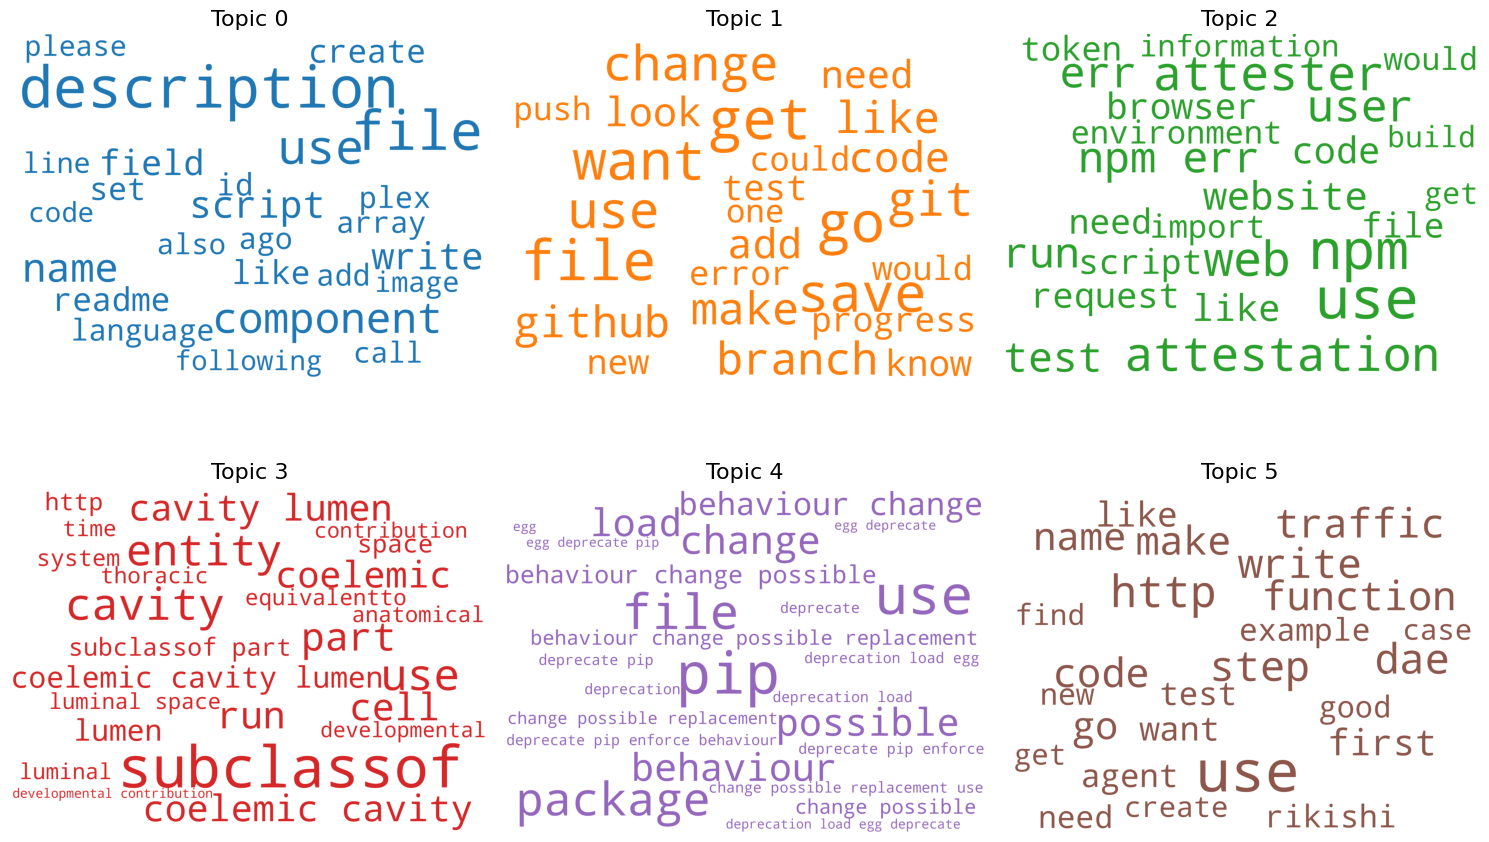

Figure 3: Topic modelling for pull requests dataset

Model coherence score: 0.5983
Model perplexity: 29054.8214
-----------------------------------------------------------------------
Topic modelling for code files.
Topic #1 :
[('use', 587.19), ('data', 544.48), ('student', 440.83), ('skill', 418.83), ('match', 408.34), ('like', 382.22), ('state', 366.67), ('life', 366.54), ('process', 328.45), ('life skill', 315.01)]
Topic #2 :
[('make', 452.3), ('code', 413.56), ('use', 397.14), ('function', 244.73), ('would', 242.72), ('like', 239.67), ('user', 236.66), ('agent', 220.17), ('call', 216.82), ('write', 215.98)]
Topic #3 :
[('use', 709.31), ('code', 512.33), ('need', 405.27), ('user', 397.69), ('make', 385.66), ('task', 350.04), ('like', 339.89), ('function', 318.89), ('process', 311.58), ('time', 299.22)]
Topic #4 :
[('make', 1052.92), ('workshop', 1044.2), ('use', 907.5), ('student', 746.34), ('work', 618.41), ('actor', 615.49), ('step', 502.62), ('question', 496.55), ('feedback', 479

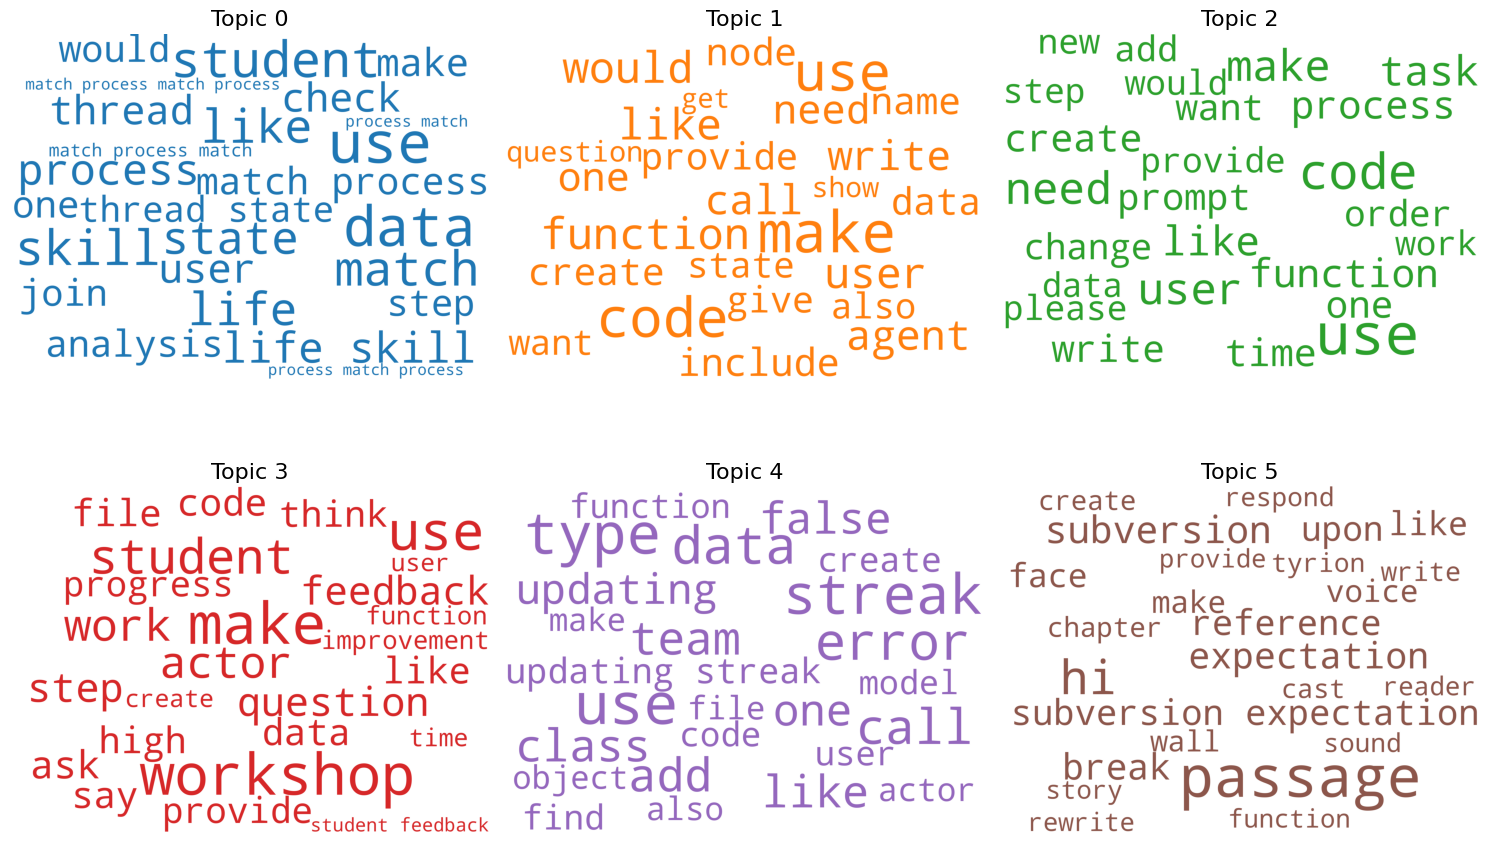

Figure 4: Topic modelling for code files dataset

Model coherence score: 0.5891
Model perplexity: 238274.1080
-----------------------------------------------------------------------
Topic modelling for hacker news.
Topic #1 :
[('point', 58.17), ('like', 55.88), ('think', 49.16), ('one', 47.17), ('use', 46.22), ('time', 45.65), ('game', 36.17), ('work', 34.17), ('image', 34.08), ('get', 33.99)]
Topic #2 :
[('like', 42.17), ('use', 37.17), ('user', 34.97), ('game', 29.17), ('give', 26.67), ('chain', 26.17), ('go', 25.17), ('please', 24.69), ('get', 24.17), ('try', 24.16)]
Topic #3 :
[('death', 63.17), ('like', 54.17), ('would', 45.08), ('one', 41.17), ('error', 40.98), ('english', 40.17), ('use', 40.11), ('medical', 37.97), ('think', 37.17), ('say', 32.13)]
Topic #4 :
[('like', 26.17), ('one', 22.16), ('give', 21.66), ('make', 21.17)]
Topic #5 :
[('use', 49.17), ('like', 38.17), ('think', 38.17), ('one', 35.17), ('reddit', 35.17), ('service', 35.17), ('could', 32.17), ('make', 32.16), ('

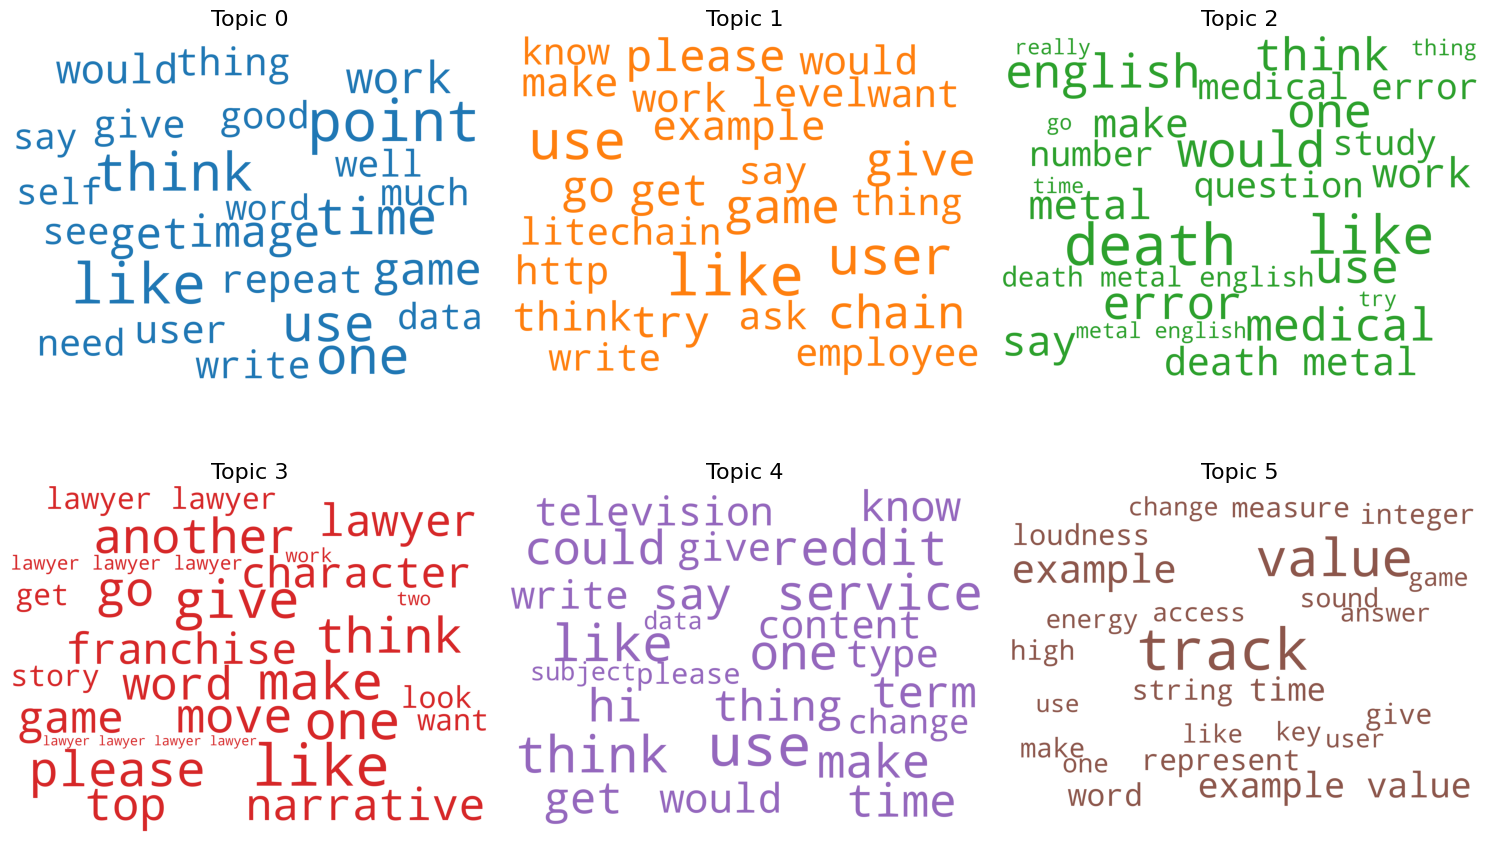

Figure 5: Topic modelling for hacker news dataset

Model coherence score: nan
Model perplexity: 63865.7417


In [13]:
random_state = 42
n_topics = 6
max_iterations = 10
n_top_words_per_topic = 25

for i, df in enumerate(lemmatised_dataframes):
    # Normalise prompts
    norm_corpus = [] #normalize_corpus(df["Prompts"]).flatten()
    for prompt in df.Prompts:
        norm_corpus.append(" ".join(prompt))

    # Transform corpus data into bag-of-words count matrix representation
    # Rows of the matrix represent the document, while columns are the vocabulary tokens
    #norm_corpus = ["aaaaa bbbb bbbb bbbb cccc", "bbbb", "cccc", "sffsdf cccc", "fdv cccc"]
    #stop_words = stopwords.words('english')
    cv = CountVectorizer(min_df=0., max_df=1., ngram_range = (1,4), stop_words=stop_words)
    cv_matrix = cv.fit_transform(norm_corpus)
    #X_train, X_test = train_test_split(cv_matrix, train_size=0.8, test_size=0.2, shuffle=True, random_state=random_state)
    vocabulary = cv.get_feature_names_out()

    # LDA modelling
    LDA_model = LatentDirichletAllocation(n_components=n_topics,
                                            max_iter=max_iterations,
                                            random_state=random_state)
    LDA_model.fit_transform(cv_matrix)
    #LDA_model.transform(X_test)

    #Coherence score calculation
    norm_corpus_tokens = [doc.split() for doc in norm_corpus]
    cur_coherence_score = metric_coherence_gensim(
            measure='c_v',
            top_n=5,
            topic_word_distrib=LDA_model.components_,
            dtm=cv.fit_transform(norm_corpus),
            vocab=np.array(cv.get_feature_names_out()),
            texts=norm_corpus_tokens)

    # Visualisation
    print(f"-----------------------------------------------------------------------\nTopic modelling for {dataframe_names[i]}.")
    topics_dicts = []
    for index, topic in enumerate(LDA_model.components_):
        #print(f'Top-{n_top_words_per_topic} for topic #{index}: {[cv.get_feature_names_out()[i] for i in topic.argsort()[-n_top_words_per_topic:]]}')
        topic_weights = [(token, np.round(weight, 2))
                         for token, weight in zip(vocabulary, topic)
                         ]  ## zip (word, importance_weight)
        topic_weights = sorted(topic_weights, key=lambda x: -x[1]) 
        word_weights = {}
        for weight in topic_weights:
            word_weights[weight[0]] = weight[1]
        topics_dicts.append(word_weights)
    get_topics_meanings(LDA_model.components_, vocabulary, display_weights=True, topn=10, weight_cutoff=20)
    topic_modelling_visualisation(n_top_words_per_topic, topics_dicts, dataframe_names[i], i)
    print(f'Model coherence score: {"%.4f" % np.mean(cur_coherence_score)}')
    print(f'Model perplexity: {"%.4f" % LDA_model.perplexity(cv_matrix)}')